# Analyze A/B Test Results

## Table of Contents
- [Introduction](#intro)
- [Part I - Importing and cleaning data](#part1)
- [Part II - A/B Test](#part2)
- [Part III - Logistic regression](#part3)
- [Part IV - Conclusion](#part4)

<a id='intro'></a>
## Introduction<br>
In this project I will be working to understand the results of an A/B test run by an e-commerce website. The company has developed a new web page in order to increase the number of users who "convert," meaning the number of users who decide to pay for the company's product. My goal is to understand if they should implement this new page or keep the old page.

----------------------

<a id='part1'></a>
## Importing and cleaning data

In [30]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
random.seed(42)

**importing data**

In [72]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


**missing values**

In [20]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

there is no missing values in the dataframe

**number of rows**

In [18]:
df.shape[0]

294478

**number of unique values**

In [19]:
df.nunique()

user_id         290584
timestamp       294478
group                2
landing_page         2
converted            2
dtype: int64

let's remove all the rows for which the new_page and treatment values don't match

In [73]:
df2 = df[((df['group']=='treatment')&(df['landing_page']=='new_page'))|((df['group']=='control')&(df['landing_page']=='old_page'))]

**number of unique values in the df2 dataframe**

In [88]:
df2.nunique()

user_id         290584
timestamp       290585
group                2
landing_page         2
converted            2
dtype: int64

there is duplicated user in the df2 dataframe

In [6]:
duplicated_series = (df2.groupby(['user_id'])['user_id'].count()).sort_values()

In [7]:
df2[df2['user_id']==773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


let's remove one entry as they differ by timestamp only

In [74]:
df2 = df2.drop_duplicates(subset='user_id', keep='first')
df2.nunique()

user_id         290584
timestamp       290584
group                2
landing_page         2
converted            2
dtype: int64

**cleaning data types**

In [95]:
df2.dtypes

user_id          int64
timestamp       object
group           object
landing_page    object
converted        int64
dtype: object

In [34]:
df2['timestamp'] = pd.to_datetime(df2['timestamp'])
df2.dtypes

user_id                  int64
timestamp       datetime64[ns]
group                   object
landing_page            object
converted                int64
dtype: object

data types for each column are now fine

----------------------------

<a id='part2'></a>
# A/B test

let's test if the new page generates more convertion rate (**$p_{new}$**) than the old page (**$p_{old}$**)<br>
Null hypothesis: H0: **$p_{old}$**>=**$p_{new}$**<br>
Alternative hypothesis H1: **$p_{old}$**<**$p_{new}$**

convertion rate for the whole group under the null hypothesis is:

In [75]:
p_new = p_old = df2['converted'].mean()

number of individuals in the treatment group:

In [76]:
n_new = df2[df2['group']=='treatment'].shape[0]

number of individuals in the control group:

In [77]:
n_old = df2[df2['group']=='control'].shape[0]

let's create 10000 sample distribution for each group under the null hipothesis (for **$p_{old}$**=**$p_{new}$**) :

In [78]:
p_diffs = []
np.random.seed(42)
for i in range(10000):
    new_page_converted = np.random.choice([0,1],n_new,p=(1-p_new,p_new))
    old_page_converted = np.random.choice([0,1],n_old,p=(1-p_old,p_old))
    p_diffs.append(new_page_converted.mean() - old_page_converted.mean())

actual convertion rate for control group

In [79]:
conv_rate_control = df2[(df2['group']=='control')&(df2['converted']==1)].shape[0]/df2[df2['group']=='control'].shape[0]

actual convertion rate for treatment group

In [80]:
conv_rate_treatment = df2[(df2['group']=='treatment')&(df2['converted']==1)].shape[0]/df2[df2['group']=='treatment'].shape[0]

difference in convertion rate for treatment and control group

In [81]:
actual_difference = conv_rate_treatment - conv_rate_control

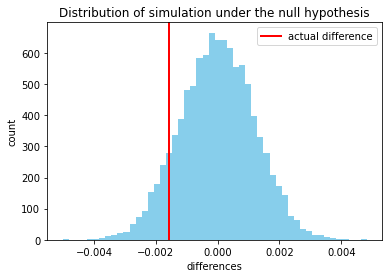

In [82]:
plt.hist(p_diffs, bins=50, color="skyblue");
plt.axvline(x=actual_difference, color='r', linewidth=2, label='actual difference')
plt.title('Distribution of simulation under the null hypothesis')
plt.xlabel('differences')
plt.ylabel('count')
plt.legend();

In [83]:
p_value = (np.array(p_diffs) > actual_difference).mean()
p_value

0.9009

**p-value is the probability of observing our statistic (or one more extreme in favor of the alternative) if the null hypothesis is true. As p-value is ~0.90 we do not have evidence to reject the null hypothsis which states that conversion rate for the new page is not bigger than for the old page.**

### Z-test

**We can also compute p-value using z-test from 'statsmodel' library**<br> The Two-Sample Z-test is used to compare the means of two samples to see if it is feasible that they come from the same population. The null hypothesis is: the population means are equal.

In [35]:
import statsmodels.api as sm

convert_old = df2[(df2['group']=='control')&(df2['converted']==1)].shape[0]
convert_new = df2[(df2['group']=='treatment')&(df2['converted']==1)].shape[0]
n_old = df2[df2['group']=='control'].shape[0]
n_new = df2[df2['group']=='treatment'].shape[0]

In [36]:
sm.stats.proportions_ztest([convert_old,convert_new],[n_old,n_new],alternative='smaller')

(1.3109241984234394, 0.9050583127590245)

**p-value is ~0.91 which is consistent with findings from A/B testing.**

--------------

<a id='part3'></a>
## Logistic regression

**We can also investigate our dataset using logistic regression.**

### regression #1

Let's create 'intercept' column and dummy columns for control/treatment groups and perform a logistic regression with new web page as explanatory variable

In [37]:
df2['intercept'] = 1
df_dummies = pd.get_dummies(df2['group'])
df2 = df2.join(df_dummies)

In [38]:
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,control,treatment
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,1,0


In [47]:
log_mod = sm.Logit(df2['converted'], df2[['intercept','treatment']])
results = log_mod.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212780.3502
Date:               2021-08-22 22:13 BIC:              212801.5095
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           1                LL-Null:          -1.0639e+05
Df Residuals:       290582           LLR p-value:      0.18988    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
treatment    -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

**p-value for 'treatment' variable is ~0.19 which means that we do not have the evidence to reject the null hypothesis which states that 'treatment' (new web page) variable is statistically insignificant for predicting conversion rate**

### regression #2

Let's upload and join country data in order to test if the conversion rate is driven by the country in user lives. 

In [48]:
countries_df = pd.read_csv('countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,control,treatment
user_id,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,0,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,0,1


let's create a dummy columns for all countries

In [49]:
df_country_dummies = pd.get_dummies(df_new['country'])
df_new = df_new.join(df_country_dummies)

In [50]:
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,control,treatment,CA,UK,US
user_id,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,1,0,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,0,1,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,0,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,1,0,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,0,1,0,1,0


In [51]:
log_mod = sm.Logit(df_new['converted'], df_new[['intercept','UK','US']])
results = log_mod.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212780.8333
Date:               2021-08-22 22:18 BIC:              212812.5723
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           2                LL-Null:          -1.0639e+05
Df Residuals:       290581           LLR p-value:      0.19835    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0375    0.0260  -78.3639  0.0000  -2.0885  -1.9866
UK             0.0507    0.0284    1.7863  0.0740  -0.0049   0.1064
US             0.0408    0.0269    1.5178  0.1291  -0.0119   0.0935
==================================================================

"""

**p-value for both 'UK' and 'US' variables are above alpha = 0.05 which means that we do not have the evidence to reject the null hypothesis which states that the country variables are statistically insignificant for predicting conversion rate**

### regression #3

let's check if interaction between country and the new page affect conversion rate<br>
interaction columns creation:

In [52]:
df_new['treatment_CA'] = df_new['treatment'] * df_new['CA']
df_new['treatment_UK'] = df_new['treatment'] * df_new['UK']
df_new['treatment_US'] = df_new['treatment'] * df_new['US']

In [53]:
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,control,treatment,CA,UK,US,treatment_CA,treatment_UK,treatment_US
user_id,,,,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,1,0,0,1,0,0,0,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,0,1,0,0,1,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,0,1,0,1,0,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,1,0,0,1,0,0,0,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,0,1,0,1,0,0,1,0


In [54]:
log_mod = sm.Logit(df_new['converted'], df_new[['intercept','treatment','UK','US','treatment_UK','treatment_US']])
results = log_mod.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212782.6602
Date:               2021-08-22 22:18 BIC:              212846.1381
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           5                LL-Null:          -1.0639e+05
Df Residuals:       290578           LLR p-value:      0.19199    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0040    0.0364  -55.0077  0.0000  -2.0754  -1.9326
treatment     -0.0674    0.0520   -1.2967  0.1947  -0.1694   0.0345
UK             0.0118    0.0398    0.2957  0.7674  -0.0663   0.0899
US             0.0175    0.0377    0.4652  0.6418  -0.0563   0.0914
treatment_UK   0.0783    0.0568    1.3783  0.1681  -0.0330   0.1896
treatment_US   0.0469    0.0538    0.8718  0.3833  -0.0585   0.1523
==================================================================

"""

**for alpha equals to 0.05 intersection of the new page and country is statistically insignificant for predicting conversion rate**

<a id='part4'></a>
# Conclusion:

### based on the above tests new page introduction is not recommended as it was not proven that it generates more conversion rate that the old page